In [45]:
import os,sys,inspect
# current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
# parent_dir = os.path.dirname(current_dir)
# sys.path.insert(0, parent_dir) 
os.chdir('../')

from detector.detector import *
from preprocessing.deconvolution import *
from simulator.utils import *
import numpy as np
import matplotlib.pyplot as plt
from images import *
import imageio
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable
# print(parent_dir)


In [4]:
print(os.getcwd())

c:\Users\CheLiu\Documents\research\Ultracold\Ultracode\SingleAtomDetection


1) Sanity check of plt.imshow()
-------------------------------
This is just for me to practice plt.imshow() function. Below tiger.jpg is shown along with its gray scale image

In [5]:

def show_jpg(img):    
    plt.figure(figsize=(8,6))
    plt.imshow(img)
    plt.show()    



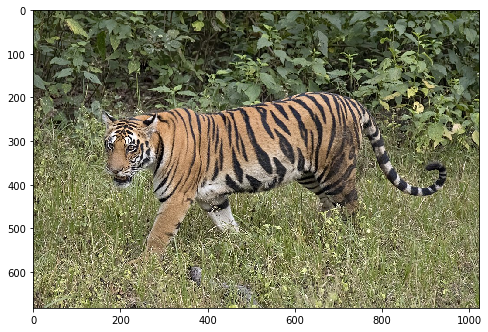

In [6]:
"""Original image"""
img_loc = 'images/tiger.jpg'

img = imageio.imread(img_loc)/255
show_jpg(img)



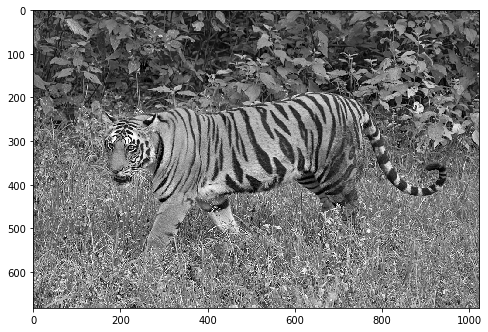

In [7]:
"""convert to grey image"""
graying = np.array(Image.fromarray(np.uint8(255*img)).convert('L')) / 255
plt.figure(figsize=(8,6))
plt.imshow(graying, cmap='gray')

In [8]:
"""
Tasks:
1. test fourier: make sure F*G = f X g
//2. convert img to grey scale
3. do a low pass filtering in fourier space see if reduces noise
4. implement deconvolution.py
5. analysis of the result 



"""


'\nTasks:\n1. test fourier: make sure F*G = f X g\n//2. convert img to grey scale\n3. do a low pass filtering in fourier space see if reduces noise\n4. implement deconvolution.py\n5. analysis of the result \n\n\n\n'

2) Sanity Checks For Fourier Transform
----------------------
This section shows how to use np.fft.fft2() to fourier transform a tiger and back

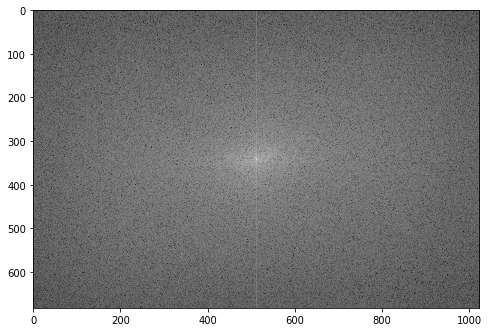

In [9]:
graying_fourier = np.fft.fftshift(np.fft.fft2(graying))
# plt.imshow(graying_fourier)
plt.figure(figsize=(8,6))
plt.imshow(np.log(np.abs(graying_fourier)+1e-8), cmap='gray')

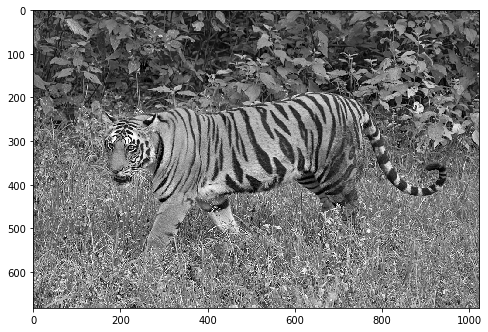

In [10]:
""" Inverse Fourier transform to restore the original image"""
graying_restore = np.fft.ifft2(graying_fourier)
plt.figure(figsize=(8,6))
plt.imshow(np.abs(graying_restore), cmap='gray')

3) Fourier Transform of Two Dots:
-----------------------------------

Suppose the two dots are located at $x_1$ and $x_2$, modeled by $\delta(x-x_1) \delta(y-0)$ and $\delta(x-x_2) \delta(y-0)$

The the Fourier Transform:
$$\int \int (\delta(x-x_1)\delta(y-0) +\delta(x-x_2)\delta(y-0)) e^{-ixk_x} e^{-iyk_y} dxdy$$
$$= e^{-ix_1k_x} + e^{-ix_2k_x}$$
$$= \cos(x_1k_x) + \cos(x_2k_x) - i\sin(x_1k_x) - i\sin(x_2k_x) $$
So the abs of the result
$$\sqrt{(\cos(x_1k_x) + \cos(x_2k_x))^2 + (\sin(x_1k_x) + \sin(x_2k_x))^2}$$
$$= \sqrt{2 + 2(\cos(x_1k_x)\cos(x_2k_x) + \sin(x_1k_x) \sin(x_2k_x))}$$
$$= \sqrt{2 + 2 \cos(x_1k_x - x_2k_x)}$$

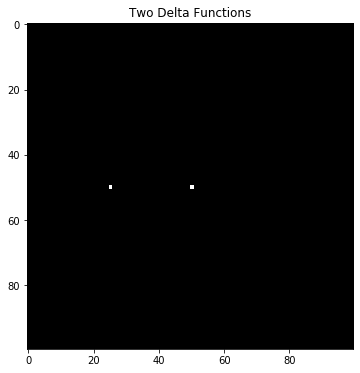

In [11]:
a = np.zeros((100,100))
a[a.shape[0]//2, a.shape[1]//2] = 1000
a[a.shape[0]//2, a.shape[1]//4] = 1000
plt.figure(figsize=(8,6))
plt.title("Two Delta Functions")
plt.imshow(a, cmap='gray')



In [12]:
a_fourier = np.fft.fftshift(np.fft.fft2(a))

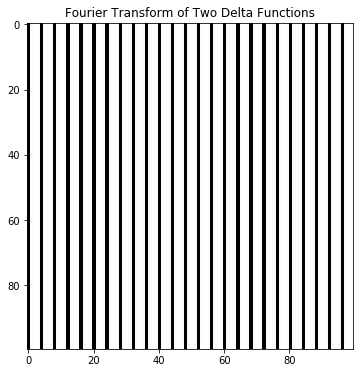

In [13]:
plt.figure(figsize=(8,6))
plt.title("Fourier Transform of Two Delta Functions")
plt.imshow(np.log(np.abs(a_fourier)+1e-8), cmap='gray')


4) Low Pass Filter in Fourier Space
--------------------------------
We can convolve a mask with an image in the original space, equivalently, we can also multiple the fourier transform of the image and the mask in fourier space to produce the same result. In Fourier space it is easier to implement a low pass filter. One just need to define a straight cut off in the fourier space. This is because Fourier space is essentially a frequency space

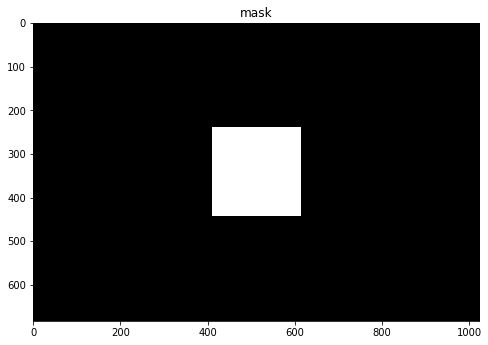

In [14]:
low_pass_mask = np.zeros(graying_fourier.shape)
H, W = low_pass_mask.shape
mask_height, mask_width = H // 5, W // 5
x = (H - mask_width) // 2
y = (W - mask_width) // 2 
low_pass_mask[x:x+mask_width, y:y+mask_width] = 1

plt.figure(figsize=(8,6))
plt.title("mask")
plt.imshow(low_pass_mask, cmap='gray')

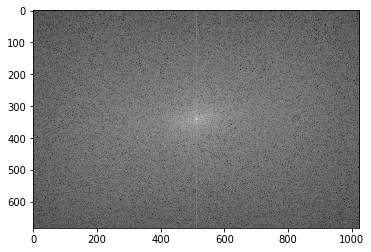

In [15]:
plt.imshow(np.log(np.abs(graying_fourier)+1e-8), cmap='gray')

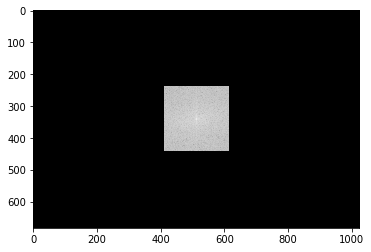

In [16]:
filtered_graying_fourier = low_pass_mask * graying_fourier
plt.imshow(np.log(np.abs(filtered_graying_fourier)+1e-8), cmap='gray')

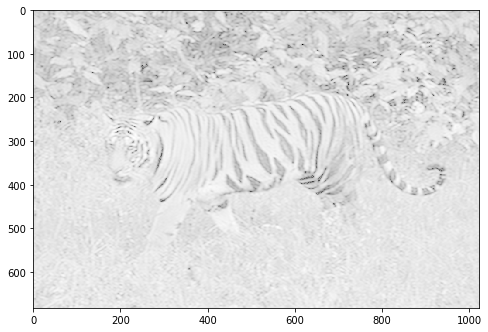

In [17]:
restored_filtered_graying = np.fft.ifft2(filtered_graying_fourier)
plt.figure(figsize=(8,6))
plt.imshow(np.log(np.abs(restored_filtered_graying) + 1e-8), cmap='gray')

5) Low Pass Filter Applied to An Atom
-----------------------------
In this section we demonstrate how the above filter can be applied to a simulated image of an atom. 
In the demonstration below, we can see that with SNR=4, the low pass filter demonstrates its usefulness. However, if SNR is lower, then performance of the filter lowers as well.

In [18]:
from simulator.utils import *
from ipywidgets import interactive, interact
import ipywidgets as widgets


Original Image


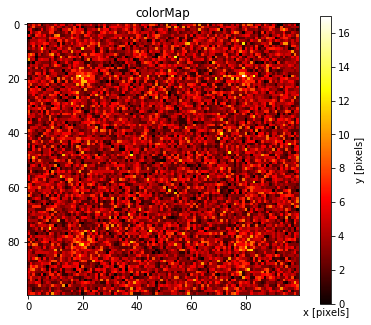

Instance info:
img_size: 100
exposure_time: 1
atom_variance: 5
quantum_efficiency: 1
atom count: 4
photons_in_background is set to 1 by default
SNR: 4
x0: [20 20 80 80]
y0: [80 20 80 20]


In [86]:
img_size = 100 
SNR = 4

sim = simulator(100, 1)
print("Original Image")
x0 = np.array([20, 20, 80, 80])
y0 = np.array([80, 20, 80, 20])
atom = sim.create_simulation_from_SNR(x0, y0, SNR, verbose=True)



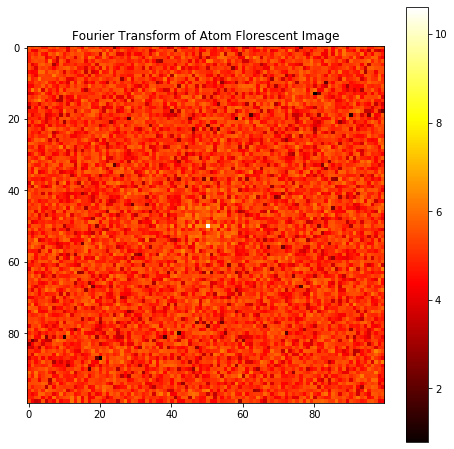

In [87]:
atom_fourier = np.fft.fftshift(np.fft.fft2(atom))
plt.figure(figsize=(8,8))
plt.imshow(np.log(np.abs(atom_fourier) + 1e-8), cmap='hot')
plt.title("Fourier Transform of Atom Florescent Image")
plt.colorbar()
plt.show()

In [81]:
# def filter_image(radii):

def make_square_mask(height, width):
    mask = np.zeros(atom_fourier.shape)
    H, W = atom_fourier.shape
    x = (H - height) // 2
    y = (W - width) // 2
    mask[x:x+height+1, y:y+width+1] = 1
    return mask

def make_circ_mask(radii):
    h, w = atom_fourier.shape
    Y, X = np.ogrid[:h, :w]
    center = (int(w / 2), int(h / 2))
    dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)

    mask = dist_from_center <= radii
    mask = np.where(mask, 1., 0.)
    return mask


# interactive_plot = interactive(make_square_mask, height=(0, atom_fourier.shape[0]), width=(0, atom_fourier.shape[0]))
# interactive_plot = interactive(make_circ_mask, radii=(0, atom_fourier.shape[0]//2))
# output = interactive_plot.children[-1]
# output.layout.height = '300px'
# interactive_plot



In [91]:
def filter_atom_with_square(height, width):
    mask = make_square_mask(height, width)
    plt.figure(figsize=(15,15))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

    plt.subplot(141)
    plt.title(f"Low Pass Filter (height={height}, width={width})")
    plt.imshow(mask, cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)

    plt.subplot(142)
    plt.title("Filtered Atom in Fourier Space")
    filtered_atom_fourier = mask * atom_fourier
    plt.imshow(np.log(np.abs(filtered_atom_fourier)+1e-8), cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)

    filtered_atom = np.fft.ifft2(filtered_atom_fourier)
    plt.subplot(143)
    plt.title("Filtered Atom in Coordinate Space")
    plt.imshow(np.abs(filtered_atom), cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)

    plt.subplot(144)
    plt.title("Original Image")
    plt.imshow(atom, cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)
    plt.show()

H, W = atom_fourier.shape
interactive_plot = interactive(filter_atom_with_square, height=(0, H), width=(0, W))
output = interactive_plot.children[-1]
output.layout.height = '300px'
interactive_plot


interactive(children=(IntSlider(value=50, description='height'), IntSlider(value=50, description='width'), Out…

In [90]:
def filter_atom_with_circ(radii):
    mask = make_circ_mask(radii)
    plt.figure(figsize=(15,15))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

    plt.subplot(141)
    plt.title(f"Low Pass Filter (Radii={radii})")
    plt.imshow(mask, cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)

    plt.subplot(142)
    plt.title("Filtered Atom in Fourier Space")
    filtered_atom_fourier = mask * atom_fourier
    plt.imshow(np.log(np.abs(filtered_atom_fourier)+1e-8), cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)

    filtered_atom = np.fft.ifft2(filtered_atom_fourier)
    plt.subplot(143)
    plt.title("Filtered Atom in Coordinate Space")
    plt.imshow(np.abs(filtered_atom), cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)

    plt.subplot(144)
    plt.title("Original Image")
    plt.imshow(atom, cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)


    plt.show()

H, W = atom_fourier.shape
interactive_plot = interactive(filter_atom_with_circ, radii=(0, H//2))
output = interactive_plot.children[-1]
output.layout.height = '300px'
interactive_plot

interactive(children=(IntSlider(value=25, description='radii', max=50), Output(layout=Layout(height='300px')))…

6) Defining Filter in Fourier Space VS Defining Filter in Coordinate Space
--------------------------------------------------


In [104]:
def filter_atom_with_square_coord_space(height, width):
    mask = make_square_mask(height, width)
    plt.figure(figsize=(15,15))
    plt.subplots_adjust(wspace=0.5)

    plt.subplot(241)
    plt.title(f"Low Pass Filter in Fourier Space\n(height={height}, width={width})")
    mask_fourier = np.fft.fftshift(np.fft.fft2(mask))
    plt.imshow(np.abs(mask_fourier), cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)

    plt.subplot(242)
    plt.title("Filtered Atom in Fourier Space")
    filtered_atom_fourier = mask_fourier * atom_fourier
    plt.imshow(np.log(np.abs(filtered_atom_fourier)+1e-8), cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)

    filtered_atom = np.fft.ifft2(filtered_atom_fourier)
    plt.subplot(243)
    plt.title("Filtered Atom in Coordinate Space")
    plt.imshow(np.abs(filtered_atom), cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)

    plt.subplot(244)
    plt.title("Original Image")
    plt.imshow(atom, cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)
    plt.show()

  
H, W = atom_fourier.shape
interactive_plot = interactive(filter_atom_with_square_coord_space, height=(0, H), width=(0, W))
output = interactive_plot.children[-1]
output.layout.height = '300px'
interactive_plot

interactive(children=(IntSlider(value=50, description='height'), IntSlider(value=50, description='width'), Out…

In [108]:
def filter_atom_with_square_fourier_space(height, width):
    mask = make_square_mask(height, width)
    plt.figure(figsize=(15,15))
    plt.subplots_adjust(wspace=0.5)

    plt.subplot(241)
    plt.title(f"Low Pass Filter in Fourier Space\n(height={height}, width={width})")
    plt.imshow(mask, cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)

    plt.subplot(242)
    plt.title("Filtered Atom in Fourier Space")
    filtered_atom_fourier = mask * atom_fourier*20000
    plt.imshow(np.log(np.abs(filtered_atom_fourier)+1e-8), cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)

    filtered_atom = np.fft.ifft2(filtered_atom_fourier)
    plt.subplot(243)
    plt.title("Filtered Atom in Coordinate Space")
    plt.imshow(np.abs(filtered_atom), cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)

    plt.subplot(244)
    plt.title("Original Image")
    plt.imshow(atom, cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)
    plt.show()
H, W = atom_fourier.shape
interactive_plot = interactive(filter_atom_with_square_fourier_space, height=(0, H), width=(0, W))
output = interactive_plot.children[-1]
output.layout.height = '300px'
interactive_plot

interactive(children=(IntSlider(value=50, description='height'), IntSlider(value=50, description='width'), Out…

In [114]:
def filter_atom_with_circ_coord_space(radii):
    mask = make_circ_mask(radii)
    plt.figure(figsize=(15,15))
    plt.subplots_adjust(wspace=0.5)

    plt.subplot(241)
    plt.title(f"Low Pass Filter in Fourier Space\n(radii={radii})")
    mask_fourier = np.fft.fftshift(np.fft.fft2(mask))
    plt.imshow(np.abs(mask_fourier), cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)

    plt.subplot(242)
    plt.title("Filtered Atom in Fourier Space")
    filtered_atom_fourier = mask_fourier * atom_fourier
    plt.imshow(np.log(np.abs(filtered_atom_fourier)+1e-8), cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)

    # filtered_atom = np.fft.fftshift(np.fft.ifft2(filtered_atom_fourier))
    filtered_atom = np.fft.ifft2(filtered_atom_fourier)
    plt.subplot(243)
    plt.title("Filtered Atom in Coordinate Space")
    plt.imshow(np.abs(filtered_atom), cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)

    plt.subplot(244)
    plt.title("Original Image")
    plt.imshow(atom, cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)
    plt.show()

  
H, W = atom_fourier.shape
interactive_plot = interactive(filter_atom_with_circ_coord_space, radii=(0,H//2))
output = interactive_plot.children[-1]
output.layout.height = '300px'
interactive_plot

interactive(children=(IntSlider(value=25, description='radii', max=50), Output(layout=Layout(height='300px')))…

In [112]:
def filter_atom_with_circ_fourier_space(radii):
    mask = make_circ_mask(radii)
    plt.figure(figsize=(15,15))
    plt.subplots_adjust(wspace=0.5)

    plt.subplot(241)
    plt.title(f"Low Pass Filter in Fourier Space\n(radii={radii})")
    plt.imshow(mask, cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)

    plt.subplot(242)
    plt.title("Filtered Atom in Fourier Space")
    filtered_atom_fourier = mask * atom_fourier
    plt.imshow(np.log(np.abs(filtered_atom_fourier)+1e-8), cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)

    filtered_atom = np.fft.ifft2(filtered_atom_fourier)
    plt.subplot(243)
    plt.title("Filtered Atom in Coordinate Space")
    plt.imshow(np.abs(filtered_atom), cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)

    plt.subplot(244)
    plt.title("Original Image")
    plt.imshow(atom, cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)
    plt.show()

  
H, W = atom_fourier.shape
interactive_plot = interactive(filter_atom_with_circ_fourier_space, radii=(0,H//2))
output = interactive_plot.children[-1]
output.layout.height = '300px'
interactive_plot

interactive(children=(IntSlider(value=25, description='radii', max=50), Output(layout=Layout(height='300px')))…

7) Filtering of pure noise
---------------------------
This is to make sure that when processing noise, there should not be any bright spots resembling atoms


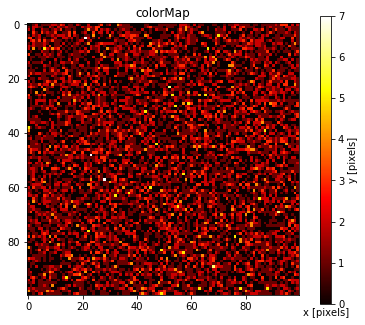

Instance info:
img_size: 100
exposure_time: 1
atom_variance: 5
quantum_efficiency: 1
atom count: 0
photons_in_background is set to 1 by default
SNR: 4
x0: [20 20 80 80]
y0: [80 20 80 20]


In [115]:
noise = sim.create_simulation_from_SNR(x0, y0, SNR, no_atom=True, verbose=True)

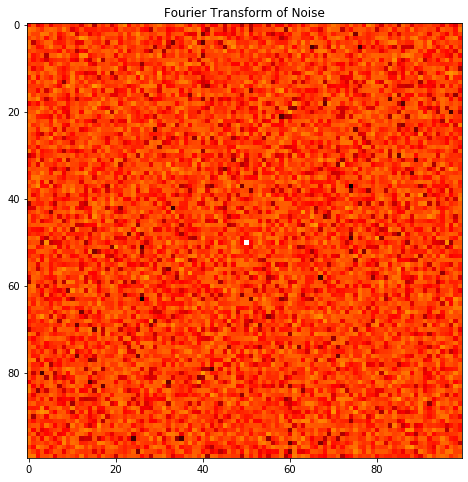

In [117]:
noise_fourier = np.fft.fftshift(np.fft.fft2(noise))
plt.figure(figsize=(8,8))
plt.title("Fourier Transform of Noise")
plt.imshow(np.log(np.abs(noise_fourier)+1e-8), cmap='hot')
plt.show()

In [120]:
def filter_atom_with_circ_fourier_space(radii):
    mask = make_circ_mask(radii)
    plt.figure(figsize=(15,15))
    plt.subplots_adjust(wspace=0.5)

    plt.subplot(241)
    plt.title(f"Low Pass Filter in Fourier Space\n(radii={radii})")
    plt.imshow(mask, cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)

    plt.subplot(242)
    plt.title("Filtered Noise in Fourier Space")
    filtered_noise_fourier = mask * noise_fourier
    plt.imshow(np.log(np.abs(filtered_noise_fourier)+1e-8), cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)

    filtered_noise = np.fft.ifft2(filtered_noise_fourier)
    plt.subplot(243)
    plt.title("Filtered Noise in Coordinate Space")
    plt.imshow(np.abs(filtered_noise), cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)

    plt.subplot(244)
    plt.title("Original Image")
    plt.imshow(noise, cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)
    plt.show()

  
H, W = atom_fourier.shape
interactive_plot = interactive(filter_atom_with_circ_fourier_space, radii=(0,H//2))
output = interactive_plot.children[-1]
output.layout.height = '300px'
interactive_plot

interactive(children=(IntSlider(value=25, description='radii', max=50), Output(layout=Layout(height='300px')))…